In [76]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sgp4.api import Satrec
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import io
import sys

In [ ]:
SPACETRACK_USER = 'USER'
SPACETRACK_PASS = 'PASS'
SPACETRACK_URI = "https://www.space-track.org"
SPACETRACK_LOGIN_URL = SPACETRACK_URI + '/ajaxauth/login'
SPACETRACK_LOGOUT_URL = SPACETRACK_URI + '/ajaxauth/logout'
SPACETRACK_QUERY_URL = SPACETRACK_URI + '/basicspacedata/query'

In [116]:
NORAD_ID = 23560 # ERS-2
MONTHS_PRIOR = 3

In [117]:
GM_EARTH = 3.986004418e14 # m^3/s^2 (WGS84)
R_EARTH = 6378137.0      # meters (WGS84 Earth radius)

In [118]:
def calculate_epoch_dt(satrec_obj):
    """Calculates datetime object from Satrec epoch fields."""
    year = satrec_obj.epochyr
    if year < 57:  # Y2K fix
        year += 2000
    else:
        year += 1900
    day = satrec_obj.epochdays
    day_int = int(day)
    frac_day = day - day_int
    base_date = datetime(year, 1, 1)
    dt_epoch = base_date + timedelta(days=day_int - 1, seconds=frac_day * 86400.0)
    return dt_epoch

In [119]:
print(f"Attempting to fetch data for NORAD ID: {NORAD_ID}...")

latest_tle_data = None
tle_data = None
latest_epoch_dt = None
tle_line1_latest = None
tle_line2_latest = None

try:
    with requests.Session() as session:
        # --- Login (Once) ---
        login_data = {'identity': SPACETRACK_USER, 'password': SPACETRACK_PASS}
        login_response = session.post(SPACETRACK_LOGIN_URL, data=login_data)
        login_response.raise_for_status() # Raise exception for bad status (4xx or 5xx)
        print("Space-Track login successful.")

        # --- Fetch Latest TLE ---
        latest_tle_query_url = (f"{SPACETRACK_QUERY_URL}/class/tle/"
                                f"NORAD_CAT_ID/{NORAD_ID}/orderby/EPOCH%20desc/limit/1/format/tle")
        latest_tle_response = session.get(latest_tle_query_url)
        latest_tle_response.raise_for_status()
        latest_tle_data = latest_tle_response.text.strip()
        print("Fetched latest TLE.")

        # --- Parse Latest TLE and Determine Date Range ---
        if not latest_tle_data or len(latest_tle_data.splitlines()) < 2:
            print(f"Error: No valid latest TLE data found for NORAD ID {NORAD_ID}. Exiting.")
            sys.exit(1) # Exit if no TLE found

        latest_lines = latest_tle_data.splitlines()
        tle_line1_latest = latest_lines[-2].strip() # Take last two lines
        tle_line2_latest = latest_lines[-1].strip()

        if tle_line1_latest.startswith('1 ') and tle_line2_latest.startswith('2 '):
            try:
                sat_latest = Satrec.twoline2rv(tle_line1_latest, tle_line2_latest)
                latest_epoch_dt = calculate_epoch_dt(sat_latest) # Use helper function
            except Exception as e:
                print(f"Error parsing the latest TLE's epoch: {e}. TLE:\n{tle_line1_latest}\n{tle_line2_latest}\nExiting.")
                sys.exit(1)
        else:
            print(f"Error: Fetched latest data does not look like a valid TLE:\n{latest_tle_data}\nExiting.")
            sys.exit(1)

        # Calculate Date Range
        END_DATE_dt = latest_epoch_dt
        START_DATE_dt = END_DATE_dt - relativedelta(months=MONTHS_PRIOR)
        END_DATE_str = END_DATE_dt.strftime('%Y-%m-%d') # Use just the date part for the range query
        START_DATE_str = START_DATE_dt.strftime('%Y-%m-%d')

        print(f"Latest TLE Epoch: {latest_epoch_dt.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]} UTC")
        print(f"Querying TLEs from {START_DATE_str} to {END_DATE_str}")

        # --- Fetch Historical TLEs for the Date Range ---
        query_url = (f"{SPACETRACK_QUERY_URL}/class/tle/NORAD_CAT_ID/{NORAD_ID}/"
                     f"EPOCH/{START_DATE_str}--{END_DATE_str}/orderby/EPOCH%20asc/format/tle")
        tle_response = session.get(query_url)
        tle_response.raise_for_status()
        tle_data = tle_response.text
        print(f"Successfully fetched historical TLE data ({len(tle_data.splitlines()) // 2} sets found).")

        # --- Logout (Once, optional but good practice) ---
        try:
            logout_response = session.get(SPACETRACK_LOGOUT_URL)
            # No need to raise_for_status on logout, just try
            print("Logged out from Space-Track.")
        except Exception as e:
            print(f"Warning: Could not log out cleanly: {e}")

except requests.exceptions.RequestException as e:
    print(f"Fatal Error during Space-Track communication: {e}.")
    print("Check credentials, network connection, and Space-Track status. Exiting.")
    sys.exit(1)
except Exception as e:
    print(f"An unexpected error occurred during data acquisition: {e}. Exiting.")
    sys.exit(1)

# --- Check if essential data was fetched ---
if tle_data is None or latest_epoch_dt is None:
     print("Error: Failed to retrieve necessary data from Space-Track. Exiting.")
     sys.exit(1)

Attempting to fetch data for NORAD ID: 23560...
Space-Track login successful.
Fetched latest TLE.
Latest TLE Epoch: 2024-02-21 15:49:35.026 UTC
Querying TLEs from 2023-11-21 to 2024-02-21
Successfully fetched historical TLE data (303 sets found).
Logged out from Space-Track.


In [120]:
print("Parsing historical TLEs...")
lines = tle_data.strip().splitlines()
tles = []

line_idx = 0
while line_idx < len(lines) - 1:
    line1 = lines[line_idx].strip()
    line2 = lines[line_idx+1].strip()

    if not line1 or not line2:
        line_idx += 1
        continue

    if line1.startswith('1 ') and line2.startswith('2 '):
        try:
            sat = Satrec.twoline2rv(line1, line2)
            dt_epoch = calculate_epoch_dt(sat) # Use helper function

            # Extract ndot/2 directly from TLE Line 1 (columns 34-43)
            # (Keeping the original robust parsing logic)
            ndot_raw = line1[33:43].strip()
            ndot_formatted = "0.0" # Default value
            if ndot_raw: # Process only if not empty
                # Add implicit decimal point if missing and format allows
                if '.' not in ndot_raw and len(ndot_raw) > 1:
                    sign = ''
                    if ndot_raw.startswith(('-', '+')):
                        sign = ndot_raw[0]
                        ndot_raw = ndot_raw[1:]

                    exp_sign = ''
                    exp_val = ''
                    num_part = ndot_raw

                    # Simplified exponent detection
                    for exp_delim in ['-', '+', ' ']:
                        if exp_delim in ndot_raw:
                            parts = ndot_raw.split(exp_delim, 1)
                            if len(parts) == 2 and parts[1].isdigit():
                                num_part = parts[0]
                                exp_sign = '-' if exp_delim == '-' else '+'
                                exp_val = parts[1]
                                break # Found exponent

                    if exp_val: # If an exponent was found
                        ndot_formatted = f"{sign}.{num_part}e{exp_sign}{exp_val}"
                    elif num_part: # No exponent found, just add decimal
                         ndot_formatted = f"{sign}.{num_part}"

                else: # Already has decimal or is simple (e.g., '0')
                    ndot_formatted = ndot_raw

                # Final cleanup for scientific notation
                ndot_formatted = ndot_formatted.replace(' -','e-').replace(' +','e+')
                if 'e' not in ndot_formatted:
                     last_sign_idx = max(ndot_formatted.rfind('-'), ndot_formatted.rfind('+'))
                     if last_sign_idx > 0:
                         base = ndot_formatted[:last_sign_idx]
                         exponent = ndot_formatted[last_sign_idx:]
                         try:
                             float(base)
                             int(exponent) # Check parts are numeric
                             ndot_formatted = base + 'e' + exponent
                         except ValueError:
                             pass # Not a valid split

            # Now parse the scientific notation
            try:
                ndot_term = float(ndot_formatted)
            except ValueError:
                print(f"Warning: Could not parse ndot_term '{line1[33:43]}' (processed as '{ndot_formatted}') for TLE epoch {dt_epoch}. Setting to 0.")
                ndot_term = 0.0

            # Store parameters
            mean_motion_rad_min = sat.no_kozai
            mean_motion_rev_day = mean_motion_rad_min * (1440.0 / (2.0 * np.pi)) # 1440 = 60*24

            tles.append({
                'Epoch': dt_epoch,
                'MeanMotion_rad_min': mean_motion_rad_min,
                'MeanMotion_revday': mean_motion_rev_day,
                'Eccentricity': sat.ecco,
                'Inclination_deg': np.degrees(sat.inclo),
                'RAAN_deg': np.degrees(sat.nodeo),
                'ArgPerigee_deg': np.degrees(sat.argpo),
                'MeanAnomaly_deg': np.degrees(sat.mo),
                'Bstar': sat.bstar,
                'ndot_TERM_from_TLE': ndot_term, # ndot/2 in rev/day^2 from TLE
            })
            line_idx += 2  # Move to the next pair

        except Exception as e:
            print(f"ERROR processing TLE lines:\n{line1}\n{line2}\nError: {e}. Skipping pair.")
            line_idx += 2 # Skip this problematic pair

    else:
        # Skipping non-TLE line (less verbose in notebook)
        line_idx += 1

if not tles:
    print("No valid TLEs could be parsed from the downloaded historical data. Exiting.")
    sys.exit(1)

print(f"Successfully parsed {len(tles)} historical TLE sets.")
tle_df_raw = pd.DataFrame(tles)

Parsing historical TLEs...
Successfully parsed 303 historical TLE sets.


In [121]:
print("Calculating derived parameters...")
tle_df_raw['MeanMotion_rad_sec'] = tle_df_raw['MeanMotion_rad_min'] / 60.0
n_rad_per_sec = tle_df_raw['MeanMotion_rad_sec']

valid_n = n_rad_per_sec > 1e-9
tle_df_raw['SemiMajorAxis_m'] = np.nan
tle_df_raw.loc[valid_n, 'SemiMajorAxis_m'] = (GM_EARTH / n_rad_per_sec[valid_n]**2)**(1.0/3.0)
tle_df_raw['SemiMajorAxis_km'] = tle_df_raw['SemiMajorAxis_m'] / 1000.0

tle_df_raw['Period_sec'] = np.nan
tle_df_raw.loc[valid_n, 'Period_sec'] = 2.0 * np.pi / n_rad_per_sec[valid_n]

valid_sma = tle_df_raw['SemiMajorAxis_m'].notna()
tle_df_raw['AltitudePerigee_km'] = np.nan
tle_df_raw['AltitudeApogee_km'] = np.nan

rp = tle_df_raw.loc[valid_sma, 'SemiMajorAxis_m'] * (1.0 - tle_df_raw.loc[valid_sma, 'Eccentricity'])
ra = tle_df_raw.loc[valid_sma, 'SemiMajorAxis_m'] * (1.0 + tle_df_raw.loc[valid_sma, 'Eccentricity'])

tle_df_raw.loc[valid_sma, 'AltitudePerigee_km'] = (rp - R_EARTH) / 1000.0
tle_df_raw.loc[valid_sma, 'AltitudeApogee_km'] = (ra - R_EARTH) / 1000.0

original_rows = len(tle_df_raw)
essential_cols = ['SemiMajorAxis_m', 'AltitudePerigee_km', 'AltitudeApogee_km', 'Period_sec']
tle_df = tle_df_raw.dropna(subset=essential_cols).copy() # Create final DF
dropped_rows = original_rows - len(tle_df)
if dropped_rows > 0:
    print(f"Dropped {dropped_rows} rows due to invalid derived parameter calculations.")

if tle_df.empty:
    print("No valid data remains after calculating derived parameters. Cannot plot/analyze. Exiting.")
    sys.exit(1)

print("Derived parameter calculation complete.")
tle_df.set_index('Epoch', inplace=True)
tle_df.sort_index(inplace=True)

Calculating derived parameters...
Derived parameter calculation complete.


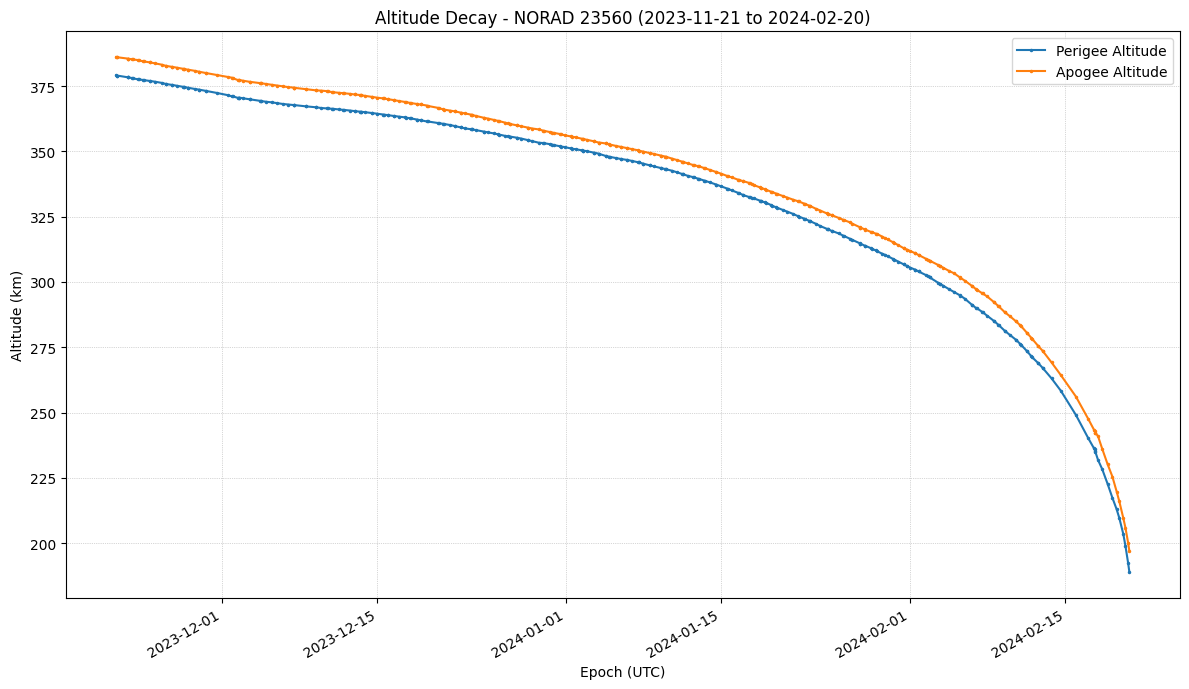

In [122]:
fig1, ax1 = plt.subplots(figsize=(12, 7))
ax1.plot(tle_df.index, tle_df['AltitudePerigee_km'], marker='.', markersize=3, linestyle='-', label='Perigee Altitude')
ax1.plot(tle_df.index, tle_df['AltitudeApogee_km'], marker='.', markersize=3, linestyle='-', label='Apogee Altitude')
ax1.set_xlabel('Epoch (UTC)')
ax1.set_ylabel('Altitude (km)')
ax1.set_title(f'Altitude Decay - NORAD {NORAD_ID} ({tle_df.index.min().strftime("%Y-%m-%d")} to {tle_df.index.max().strftime("%Y-%m-%d")})')
ax1.legend()
ax1.grid(True, which='both', linestyle=':', linewidth=0.5)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=10))
fig1.autofmt_xdate()
plt.tight_layout()
plt.show()

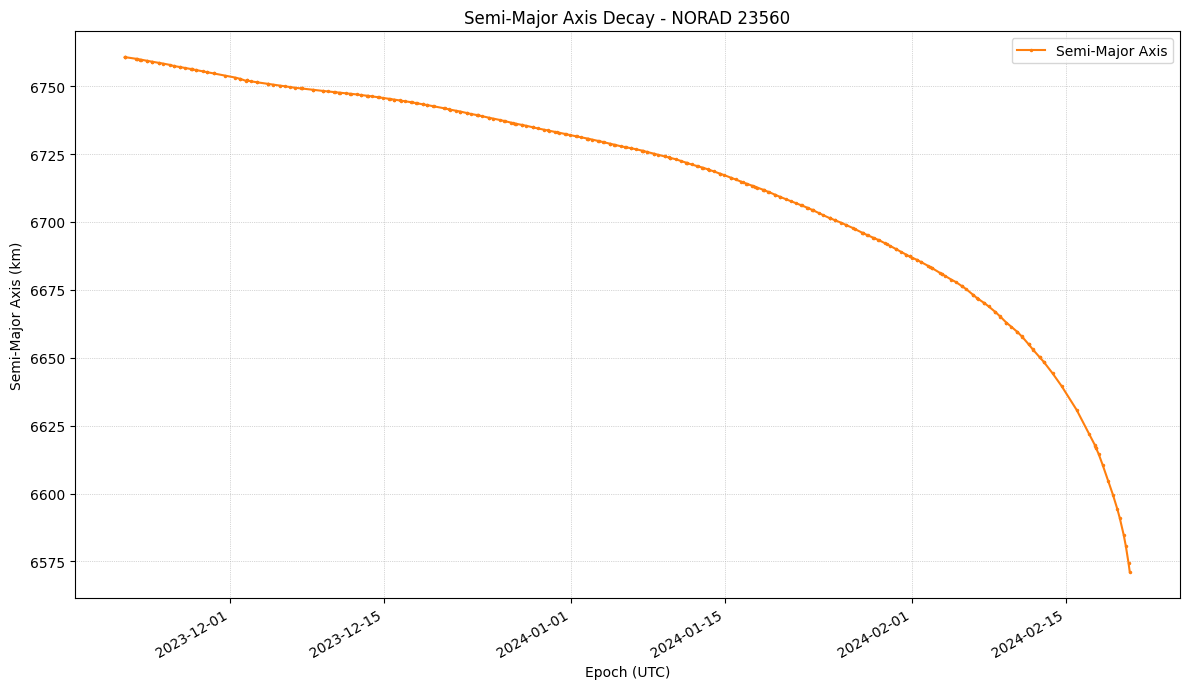

In [123]:
fig_sma, ax_sma = plt.subplots(figsize=(12, 7))
ax_sma.plot(tle_df.index, tle_df['SemiMajorAxis_km'], marker='.', markersize=3, linestyle='-', label='Semi-Major Axis', color='tab:orange')
ax_sma.set_xlabel('Epoch (UTC)')
ax_sma.set_ylabel('Semi-Major Axis (km)')
ax_sma.set_title(f'Semi-Major Axis Decay - NORAD {NORAD_ID}')
ax_sma.legend()
ax_sma.grid(True, which='both', linestyle=':', linewidth=0.5)
ax_sma.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax_sma.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=10))
fig_sma.autofmt_xdate()
plt.tight_layout()
plt.show()

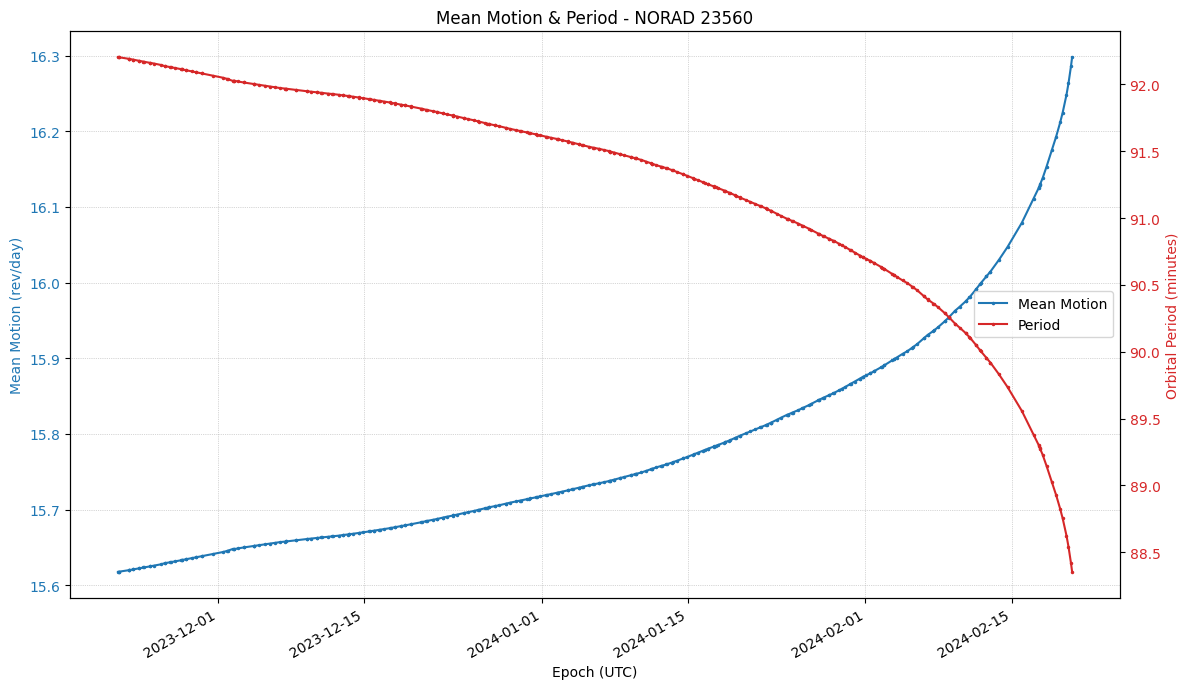

In [124]:
fig2, ax2a = plt.subplots(figsize=(12, 7))
color1 = 'tab:blue'
ax2a.plot(tle_df.index, tle_df['MeanMotion_revday'], marker='.', markersize=3, linestyle='-', color=color1, label='Mean Motion')
ax2a.set_xlabel('Epoch (UTC)')
ax2a.set_ylabel('Mean Motion (rev/day)', color=color1)
ax2a.tick_params(axis='y', labelcolor=color1)
ax2a.grid(True, which='both', linestyle=':', linewidth=0.5)
ax2a.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax2a.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=10))
ax2b = ax2a.twinx()
color2 = 'tab:red'
ax2b.plot(tle_df.index, tle_df['Period_sec'] / 60.0, marker='.', markersize=3, linestyle='-', color=color2, label='Period')
ax2b.set_ylabel('Orbital Period (minutes)', color=color2)
ax2b.tick_params(axis='y', labelcolor=color2)
ax2a.set_title(f'Mean Motion & Period - NORAD {NORAD_ID}')
lines, labels = ax2a.get_legend_handles_labels()
lines2, labels2 = ax2b.get_legend_handles_labels()
ax2b.legend(lines + lines2, labels + labels2, loc='center right')
fig2.autofmt_xdate()
plt.tight_layout()
plt.show()

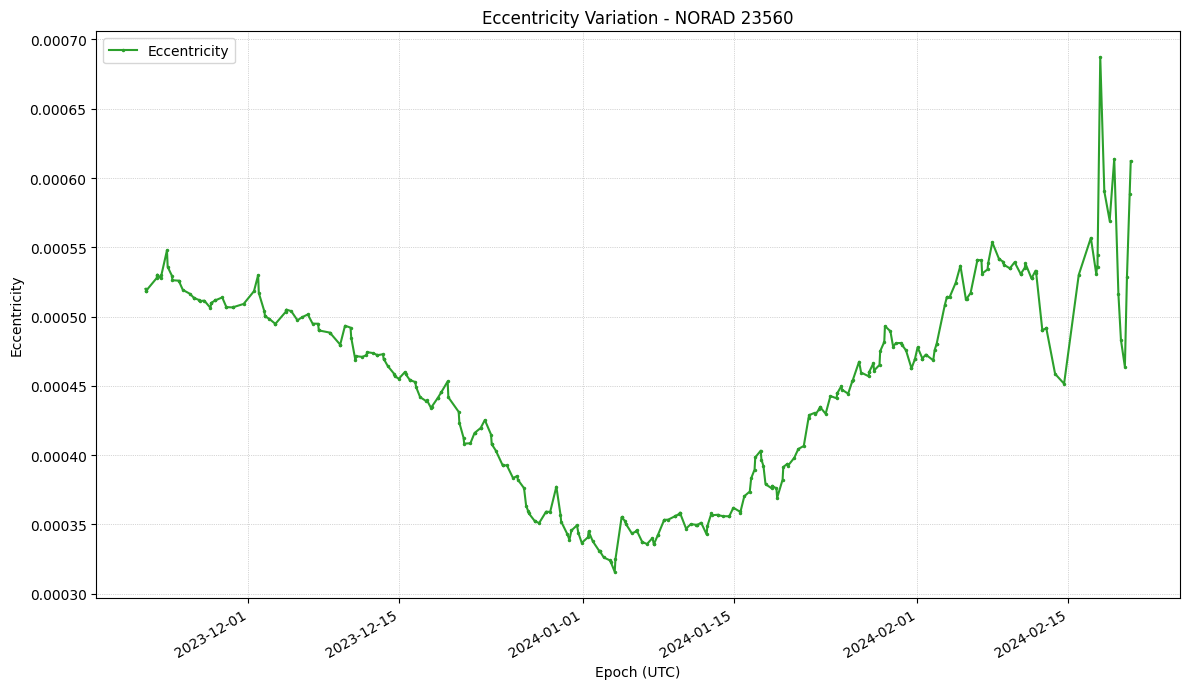

In [125]:
fig_ecc, ax_ecc = plt.subplots(figsize=(12, 7))
ax_ecc.plot(tle_df.index, tle_df['Eccentricity'], marker='.', markersize=3, linestyle='-', label='Eccentricity', color='tab:green')
ax_ecc.set_xlabel('Epoch (UTC)')
ax_ecc.set_ylabel('Eccentricity')
ax_ecc.set_title(f'Eccentricity Variation - NORAD {NORAD_ID}')
ax_ecc.legend()
ax_ecc.grid(True, which='both', linestyle=':', linewidth=0.5)
ax_ecc.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax_ecc.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=10))
fig_ecc.autofmt_xdate()
plt.tight_layout()
plt.show()

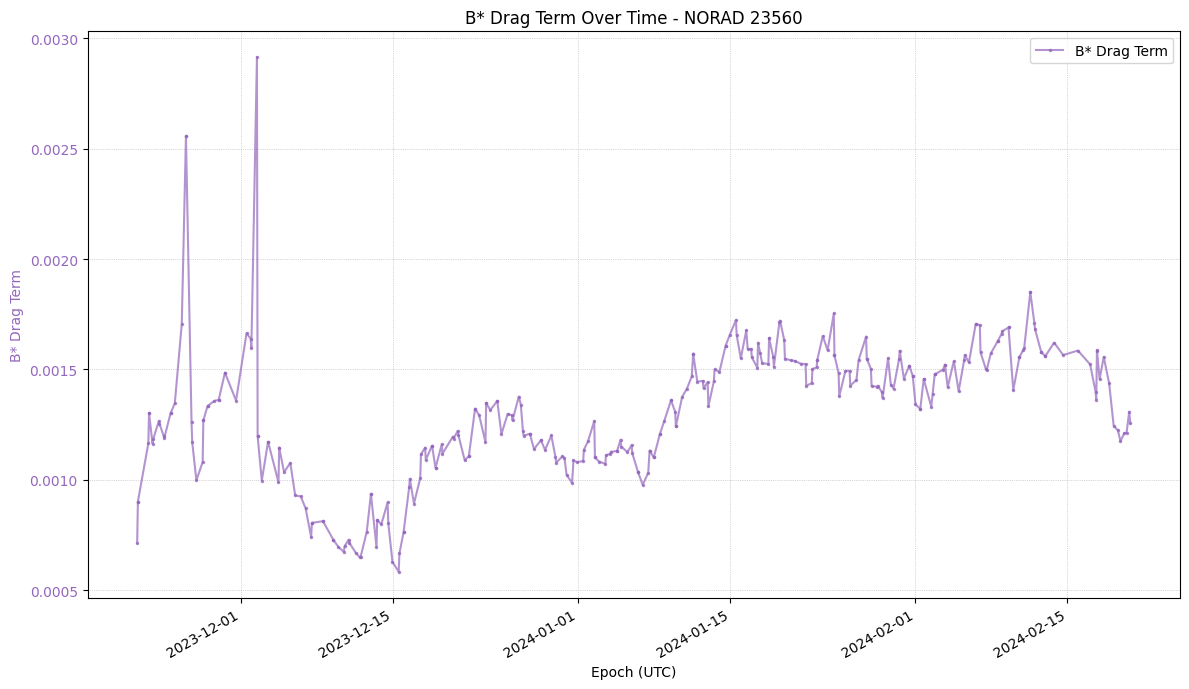

In [126]:
fig_bstar, ax_bstar = plt.subplots(figsize=(12, 7))
color1 = 'tab:purple'
ax_bstar.plot(tle_df.index, tle_df['Bstar'], marker='.', markersize=3, linestyle='-', alpha=0.7, color=color1, label='B* Drag Term')
ax_bstar.set_xlabel('Epoch (UTC)')
ax_bstar.set_ylabel('B* Drag Term', color=color1)
ax_bstar.tick_params(axis='y', labelcolor=color1)
ax_bstar.grid(True, which='both', linestyle=':', linewidth=0.5)
ax_bstar.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax_bstar.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=10))
ax_bstar.set_title(f'B* Drag Term Over Time - NORAD {NORAD_ID}')
ax_bstar.legend(loc='upper right')
fig_bstar.autofmt_xdate()
plt.tight_layout()
plt.show()

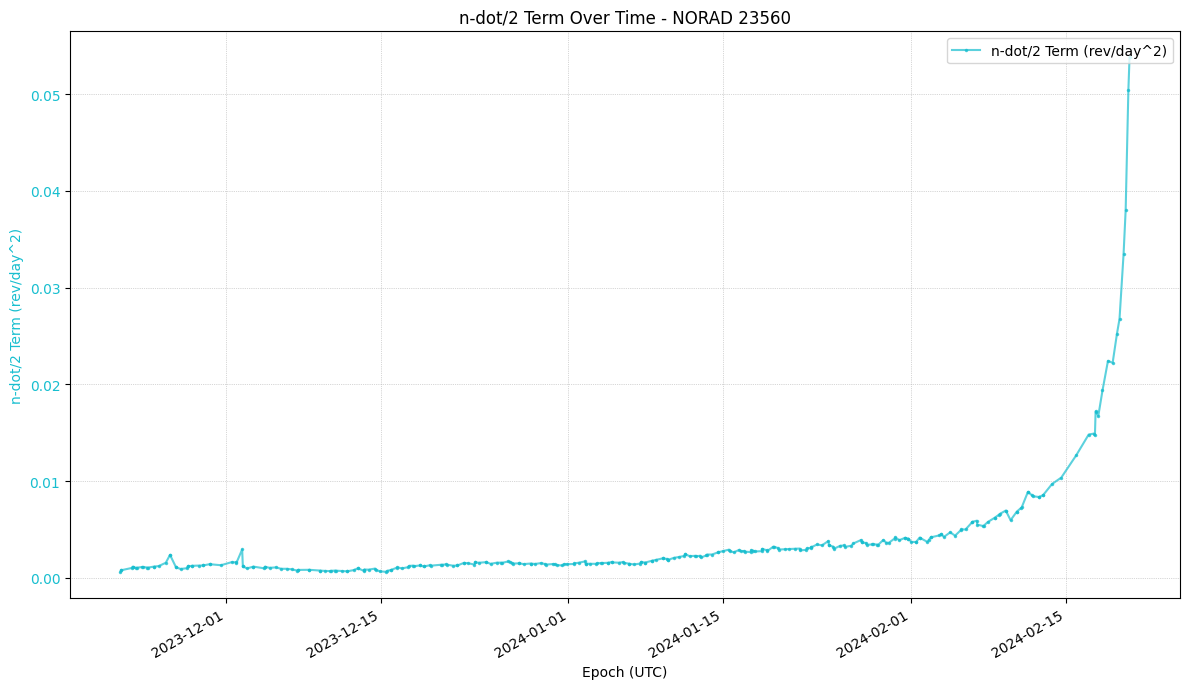

In [127]:
fig_ndot, ax_ndot = plt.subplots(figsize=(12, 7))
color2 = 'tab:cyan'
ax_ndot.plot(tle_df.index, tle_df['ndot_TERM_from_TLE'], marker='.', markersize=3, linestyle='-', alpha=0.7, color=color2, label='n-dot/2 Term (rev/day^2)')
ax_ndot.set_xlabel('Epoch (UTC)')
ax_ndot.set_ylabel('n-dot/2 Term (rev/day^2)', color=color2)
ax_ndot.tick_params(axis='y', labelcolor=color2)
ax_ndot.grid(True, which='both', linestyle=':', linewidth=0.5)
ax_ndot.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax_ndot.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=10))
ax_ndot.set_title(f'n-dot/2 Term Over Time - NORAD {NORAD_ID}')
ax_ndot.legend(loc='upper right')
fig_ndot.autofmt_xdate()
plt.tight_layout()
plt.show()

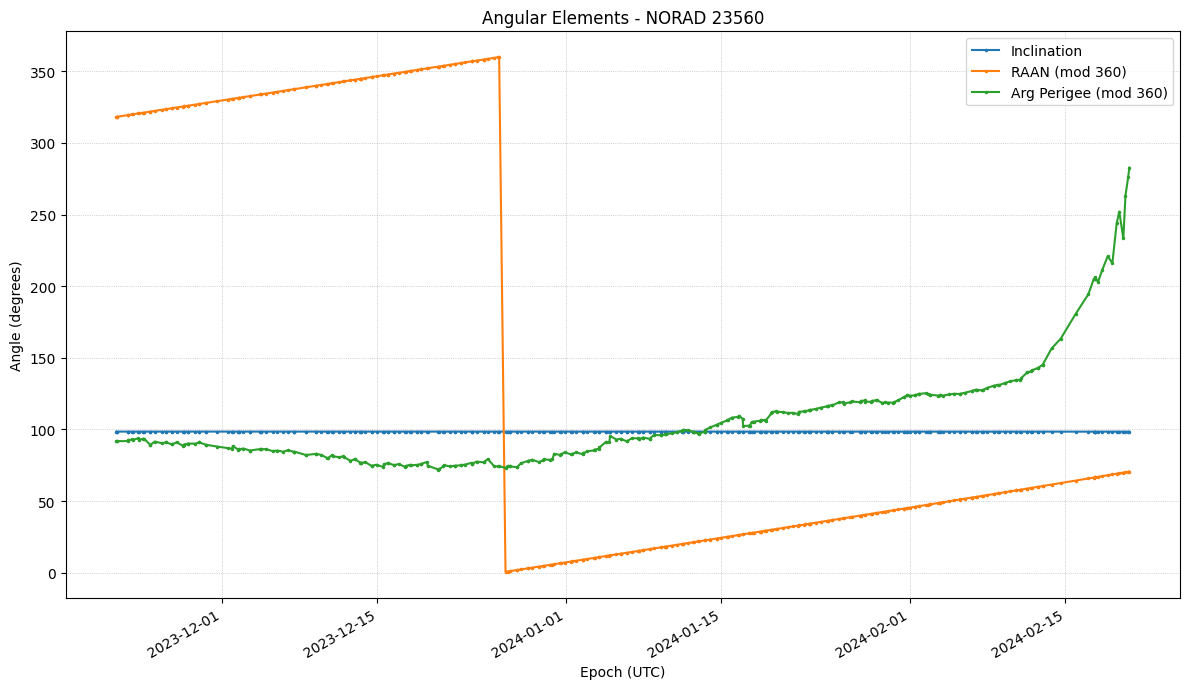

In [128]:
fig4, ax4 = plt.subplots(figsize=(12, 7))
ax4.plot(tle_df.index, tle_df['Inclination_deg'], marker='.', markersize=3, linestyle='-', label='Inclination')
ax4.plot(tle_df.index, tle_df['RAAN_deg'] % 360, marker='.', markersize=3, linestyle='-', label='RAAN (mod 360)')
ax4.plot(tle_df.index, tle_df['ArgPerigee_deg'] % 360, marker='.', markersize=3, linestyle='-', label='Arg Perigee (mod 360)')
ax4.set_xlabel('Epoch (UTC)')
ax4.set_ylabel('Angle (degrees)')
ax4.set_title(f'Angular Elements - NORAD {NORAD_ID}')
ax4.legend(loc='best')
ax4.grid(True, which='both', linestyle=':', linewidth=0.5)
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax4.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=10))
fig4.autofmt_xdate()
plt.tight_layout()
plt.show()

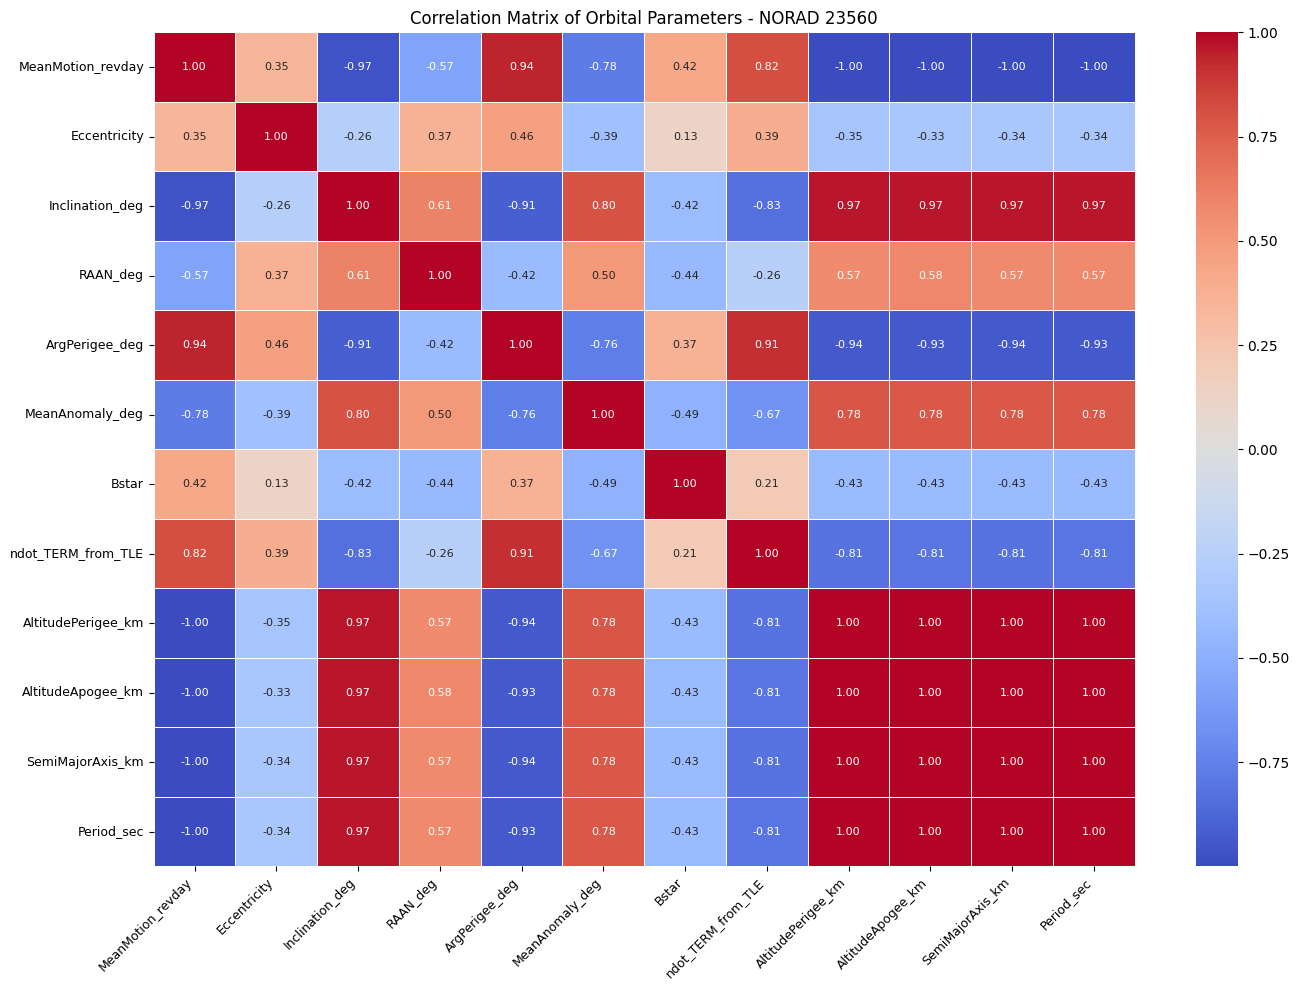

In [129]:
corr_columns = [
    'MeanMotion_revday', 'Eccentricity', 'Inclination_deg',
    'RAAN_deg', 'ArgPerigee_deg', 'MeanAnomaly_deg', 'Bstar',
    'ndot_TERM_from_TLE', 'AltitudePerigee_km', 'AltitudeApogee_km',
    'SemiMajorAxis_km', 'Period_sec'
]

valid_columns = [col for col in corr_columns if col in tle_df.columns]
corr_df = tle_df[valid_columns].dropna()

correlation_matrix = corr_df.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 8})
plt.title(f'Correlation Matrix of Orbital Parameters - NORAD {NORAD_ID}')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()